# Creating PFSS models from HMI synoptic maps

In [1]:
import drms
import pfsspy
import matplotlib.pylab as plt
import sunpy.map
import numpy as np
from astropy.io import fits
from sunpy.cm import color_tables as ct

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.
(Register to download data from JSOC [here](http://jsoc.stanford.edu/ajax/register_email.html); it is totally fine to use mbobra@stanford.edu).

In [2]:
c = drms.Client(email='mbobra@stanford.edu', verbose=True)

Query one of two synoptic maps of the radial magnetic field:
 * `hmi.Synoptic_Mr_720s` provides the imputed radial component of the magnetic field over the entire solar disk. The maps are 3600 points in Carrington longitude by 1440 points equally spaced in sine latitude.
 * `hmi.mrsynop_small_720s` is the imputed radial component of the magnetic field over the entire solar disk. The maps are 720 points in Carrington longitude by 360 points equally spaced in sine latitude. This map is produced by applying a boxcar average to the high-resolution map, hmi.Synoptic_Mr_720s.

(Text taken from [JSOC page on synoptic maps](http://jsoc.stanford.edu/HMI/LOS_Synoptic_charts.html))

Query for Carrington rotation number 2194 (associated with the active region that produced the largest X-class flare of the solar cycle):

In [3]:
jsoc_request = c.export('hmi.mrsynop_small_720s[2194]{synopMr}', protocol='fits')
#jsoc_request = c.export('hmi.mrdailysynframe_720s[2017.09.17_12:00:00_TAI]', protocol='fits')
image_url = jsoc_request.urls['url'][0]
print(image_url)
synoptic_image = fits.open(image_url)

Export request pending. [id="JSOC_20200904_1178_X_IN", status=2]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM66/D1323934046/S00000/hmi.mrsynop_small_720s.2194.synopMr.fits


Fix header keywords using the same method in the [SunPy Example Gallery](https://docs.sunpy.org/en/stable/generated/gallery/plotting/hmi_synoptic_maps.html):

In [4]:
synoptic_image[0].header["CUNIT1"] = 'degree'
synoptic_image[0].header["CUNIT2"] = 'degree'
synoptic_image[0].header["CDELT1"] *= -1
synoptic_image[0].header["CDELT2"] = 180 / np.pi * synoptic_image[0].header["CDELT2"]

Create a [SunPy Map object]()

In [5]:
synoptic_image.verify("fix")
synoptic_map = sunpy.map.Map(synoptic_image[0].data, synoptic_image[0].header)

Look at the data:

The dimensions of this image are 360 by 720.


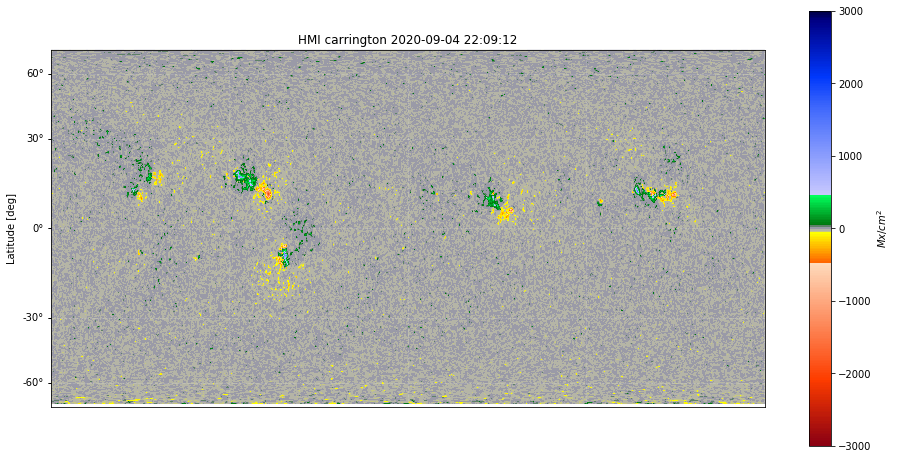

In [6]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection=synoptic_map)
hmimag = plt.get_cmap('hmimag')
im = synoptic_map.plot(vmin=-3000, vmax=3000, cmap=hmimag)
cbar = plt.colorbar(im, label='${Mx}/{cm^2}$')
print('The dimensions of this image are {} by {}.'.format(synoptic_image[0].data.shape[0], synoptic_image[0].data.shape[1]))

In [7]:
nrho = 35
rss = 2.5

In [8]:
input = pfsspy.Input(synoptic_map, nrho, rss)

In [9]:
output = pfsspy.pfss(input)

In [10]:
output.source_surface_br

ValueError: zero-size array to reduction operation minimum which has no identity

SunPy Map
---------
Observatory:		 
Instrument:		 
Detector:		 
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2020-09-04 22:09:12
Exposure Time:		 0.000000 s
Dimension:		 [720. 360.] pix
Coordinate System:	 heliographic_carrington
Scale:			 [0.5        0.31833535] deg / pix
Reference Pixel:	 [359.4 179.5] pix
Reference Coord:	 [789660.      0.] deg                   
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [11]:
output.bc[0]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan